In [1]:
from FVG import FVGStrategy
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('/Users/hatim/Desktop/Applied Forecasting/Final Project/Algo Trading/btc_daily.csv')


strategy = FVGStrategy(lookback_period=10, body_multiplier=1.2, backcandles=50, test_candles=15, upside_scaler=2, downside_scaler=1.2)
signals_df = strategy.generate_signals(df)

Calculating Position Percentages: 100%|██████████| 3551/3551 [00:00<00:00, 261504.23it/s]

Signal Generation Complete


                    PERFORMANCE SUMMARY                     

                          RETURNS                           
------------------------------------------------------------
Strategy Total Return:       39959.69%
Buy & Hold Total Return:     28079.32%
Outperformance:              11880.37%

                        RISK METRICS                        
------------------------------------------------------------
Strategy Sharpe Ratio:           1.34
Buy & Hold Sharpe Ratio:         1.11
Sharpe Improvement:             19.91%
Strategy Max Drawdown:          55.89%
Drawdown Threshold:             40.00%
Buy & Hold Max Drawdown:        83.80%
Drawdown Improvement:           33.30%

                      TRADE STATISTICS                      
------------------------------------------------------------
Win Rate:                       43.75%
Total Trades:                      32
Buy Trades:                        11
Sell Trades:                       11
Stop Loss Sells:             

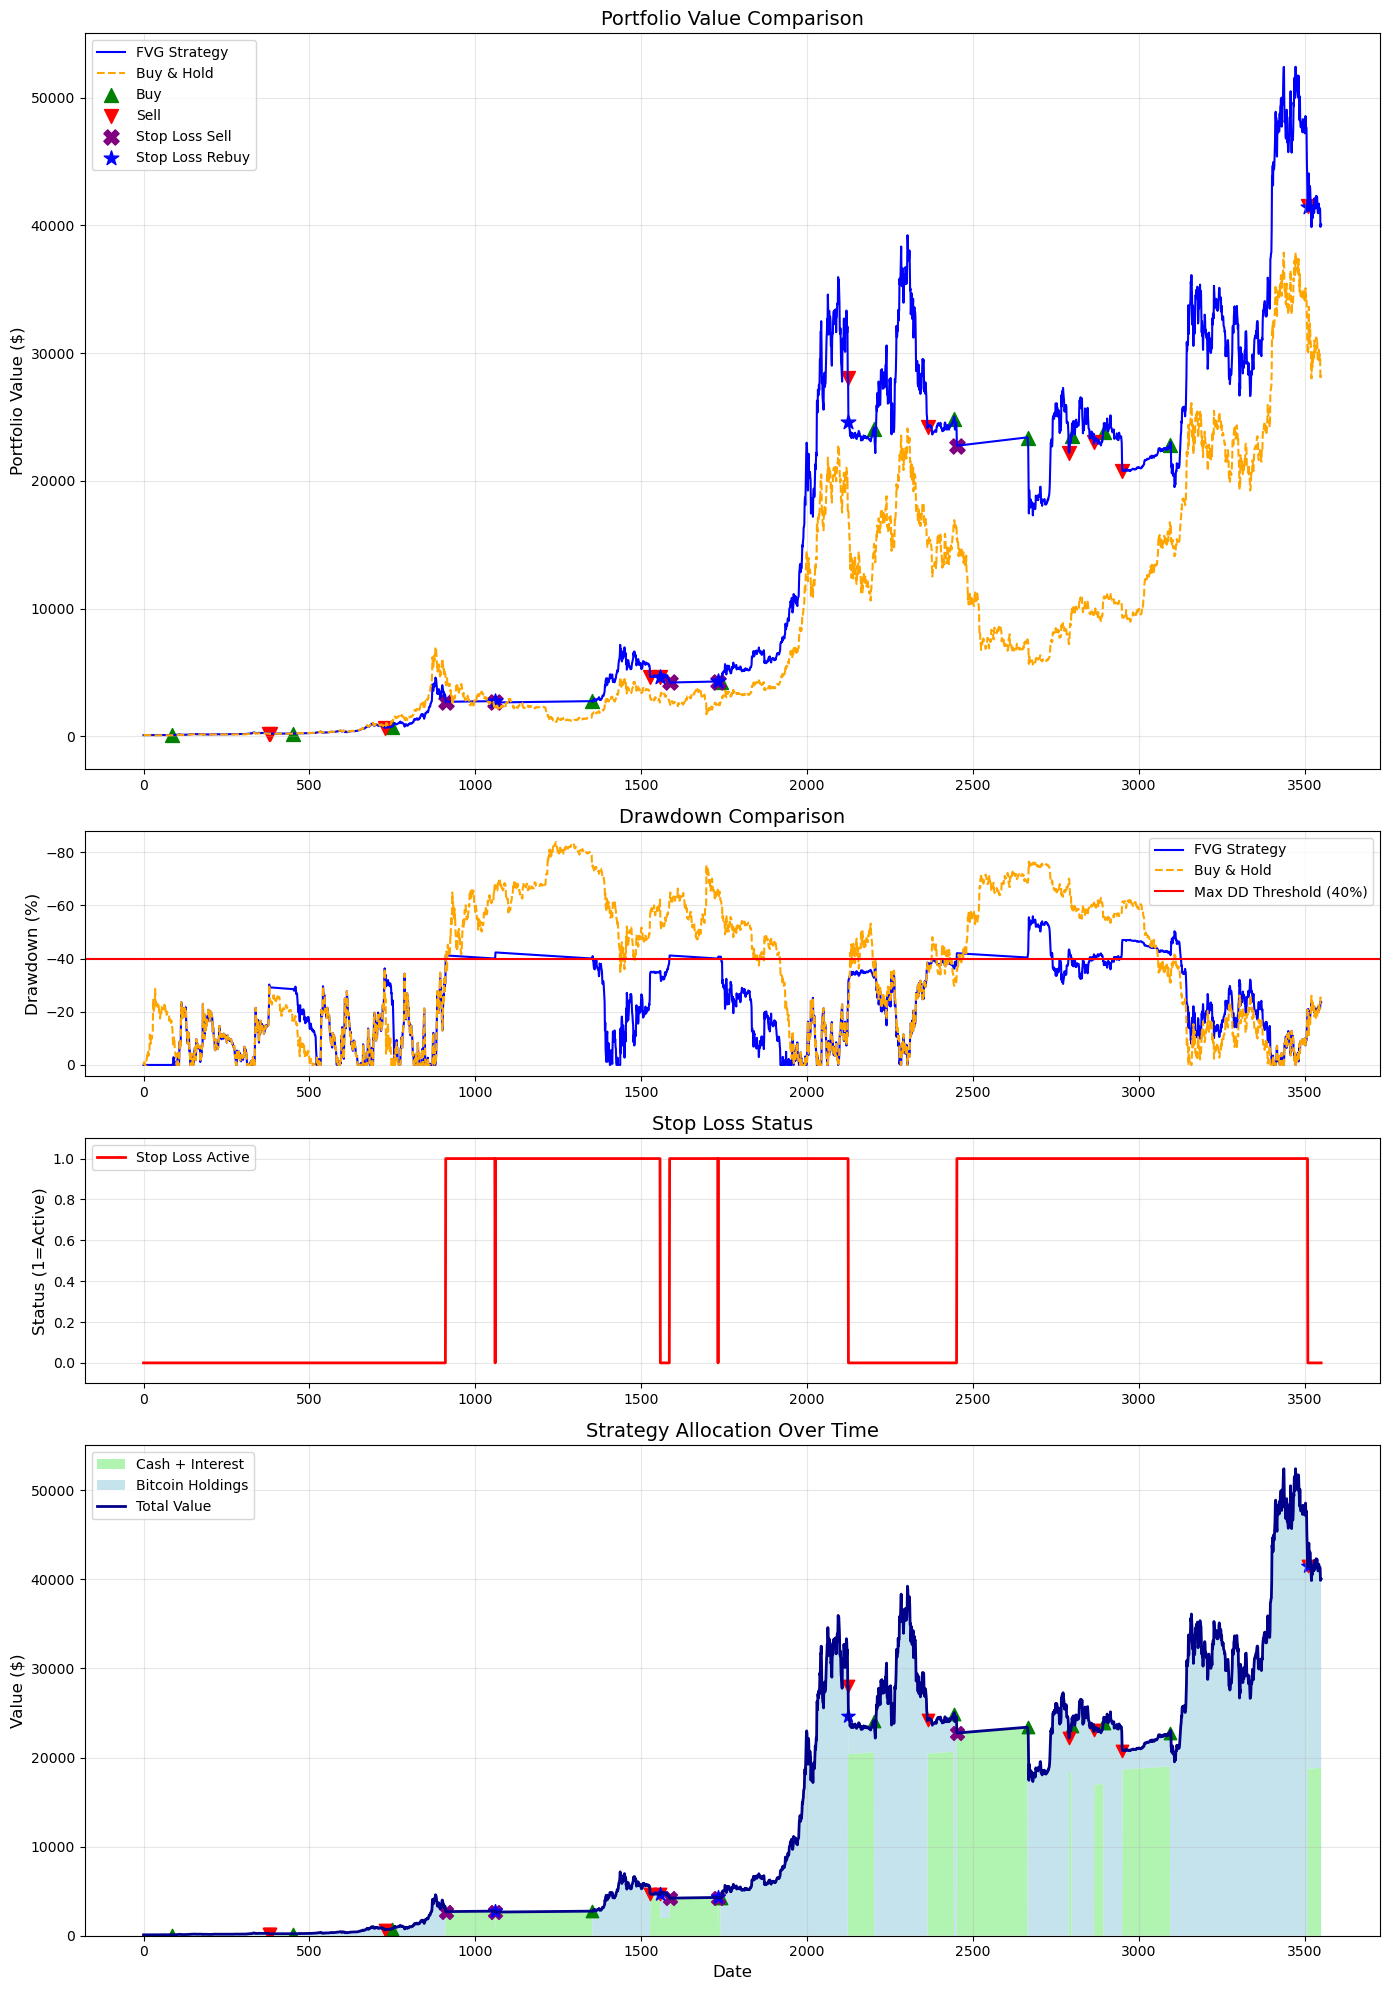

In [13]:
from evaluate import TraderWithStoploss

evaluator = TraderWithStoploss(initial_cash=100, commission_rate=0.001, risk_free_rate=0.05, max_drawdown_threshold=40)
evaluator.backtest_strategy(signals_df)
evaluator.calculate_buy_and_hold(signals_df)

# Print and visualize results
evaluator.print_performance_summary()
evaluator.plot_results()

# Hyper-paramter Tuning

In [ ]:
import pandas as pd
import numpy as np
import itertools
from tqdm import tqdm
import time


def grid_search_fvg_strategy(df, 
                            param_grid, 
                            initial_cash=100000.0, 
                            commission_rate=0.0, 
                            risk_free_rate=0.05,
                            verbose=True,
                            save_path=None):
    """
    Perform a grid search over hyperparameters for the FVG strategy.
    
    Args:
        df (DataFrame): DataFrame containing OHLC data for Bitcoin
        param_grid (dict): Dictionary mapping parameter names to lists of values to try
                          Example: {'lookback_period': [10, 20, 30], 'body_multiplier': [1.2, 1.5, 1.8]}
        initial_cash (float): Initial capital for backtesting
        commission_rate (float): Commission rate for trades
        risk_free_rate (float): Risk-free rate for cash
        verbose (bool): Whether to show progress information
        save_path (str, optional): Path to save results CSV file. If None, doesn't save.
        
    Returns:
        DataFrame: Results of grid search with metrics and parameter values
    """
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    param_combinations = list(itertools.product(*param_values))
    
    if verbose:
        print(f"Starting grid search with {len(param_combinations)} parameter combinations")
        print(f"Estimated time: {len(param_combinations) * 5} seconds (assuming ~5 seconds per combination)")
        print("=" * 60)
    
    # Initialize results storage
    results = []
    
    # Loop through parameter combinations
    for i, combination in enumerate(tqdm(param_combinations, desc="Grid Search Progress")):
        # Create parameter dictionary for this combination
        params = dict(zip(param_names, combination))
        
        if verbose and (i == 0 or (i+1) % 10 == 0):
            print(f"\nCombination {i+1}/{len(param_combinations)}: {params}")
        
        # Start timer
        start_time = time.time()
        
        try:
            # Initialize strategy with current parameters
            strategy = FVGStrategy(
                lookback_period=params.get('lookback_period', 20),
                body_multiplier=params.get('body_multiplier', 1.5),
                backcandles=params.get('backcandles', 50),
                test_candles=params.get('test_candles', 10),
                upside_scaler=params.get('upside_scaler', 1.8),
                downside_scaler=params.get('downside_scaler', 1.5)
            )
            
            # Generate signals with current parameters
            signals_df = strategy.generate_signals(df)
            
            # Initialize evaluator and run backtest
            evaluator = StrategyEvaluator(
                initial_cash=initial_cash, 
                commission_rate=commission_rate, 
                risk_free_rate=risk_free_rate
            )
            
            evaluator.backtest_strategy(signals_df)
            evaluator.calculate_buy_and_hold(signals_df)
            
            # Get performance report
            report = evaluator.generate_performance_report()
            
            # Add parameter values to report
            full_result = {**report, **params}
            
            # Add to results list
            results.append(full_result)
            
            # Calculate time taken
            elapsed_time = time.time() - start_time
            
            if verbose and (i == 0 or (i+1) % 10 == 0):
                print(f"Sharpe Ratio: {report['strategy_sharpe']:.2f}, Return: {report['strategy_return']:.2f}%, Max Drawdown: {report['strategy_max_drawdown']:.2f}%")
                print(f"Time taken: {elapsed_time:.2f} seconds")
        
        except Exception as e:
            print(f"Error with parameters {params}: {str(e)}")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by Sharpe ratio (descending)
    if not results_df.empty and 'strategy_sharpe' in results_df.columns:
        results_df = results_df.sort_values('strategy_sharpe', ascending=False)
    
    # Save results if path provided
    if save_path:
        results_df.to_csv(save_path, index=False)
        if verbose:
            print(f"\nResults saved to {save_path}")
    
    if verbose:
        print("\nGrid search complete!")
        if not results_df.empty:
            print("\nTop 5 parameter combinations by Sharpe Ratio:")
            display_cols = param_names + ['strategy_sharpe', 'strategy_return', 'strategy_max_drawdown', 'total_trades']
            print(results_df[display_cols].head(5).to_string())
    
    return results_df


# Example usage:

# Define parameter grid
param_grid = {
    'lookback_period': [10, 20, 30],
    'body_multiplier': [1.2, 1.5, 1.8],
    'backcandles': [30, 50, 70],
    'test_candles': [5, 10, 15],
    'upside_scaler': [1.5, 1.8, 2.0],
    'downside_scaler': [1.2, 1.5, 1.8]
}

# Run grid search
results = grid_search_fvg_strategy(
    df, 
    param_grid, 
    initial_cash=100000.0, 
    commission_rate=0.0, 
    risk_free_rate=0.05,
    save_path='fvg_grid_search_results.csv'
)

# Find best parameters
best_params = results.iloc[0].filter(param_grid.keys()).to_dict()
print("Best parameters:", best_params)


Starting grid search with 729 parameter combinations
Estimated time: 3645 seconds (assuming ~5 seconds per combination)


Grid Search Progress:   0%|          | 0/729 [00:00<?, ?it/s]


Combination 1/729: {'lookback_period': 10, 'body_multiplier': 1.2, 'backcandles': 30, 'test_candles': 5, 'upside_scaler': 1.5, 'downside_scaler': 1.2}


Grid Search Progress:   0%|          | 1/729 [00:05<1:07:23,  5.55s/it]

Signal Generation Complete
Error with parameters {'lookback_period': 10, 'body_multiplier': 1.2, 'backcandles': 30, 'test_candles': 5, 'upside_scaler': 1.5, 'downside_scaler': 1.2}: name 'StrategyEvaluator' is not defined


Grid Search Progress:   0%|          | 2/729 [00:11<1:06:49,  5.51s/it]

Signal Generation Complete
Error with parameters {'lookback_period': 10, 'body_multiplier': 1.2, 'backcandles': 30, 'test_candles': 5, 'upside_scaler': 1.5, 'downside_scaler': 1.5}: name 'StrategyEvaluator' is not defined


Grid Search Progress:   0%|          | 3/729 [00:16<1:08:01,  5.62s/it]

Signal Generation Complete
Error with parameters {'lookback_period': 10, 'body_multiplier': 1.2, 'backcandles': 30, 'test_candles': 5, 'upside_scaler': 1.5, 'downside_scaler': 1.8}: name 'StrategyEvaluator' is not defined


Grid Search Progress:   1%|          | 4/729 [00:22<1:07:40,  5.60s/it]

Signal Generation Complete
Error with parameters {'lookback_period': 10, 'body_multiplier': 1.2, 'backcandles': 30, 'test_candles': 5, 'upside_scaler': 1.8, 'downside_scaler': 1.2}: name 'StrategyEvaluator' is not defined


Grid Search Progress:   1%|          | 5/729 [00:28<1:07:48,  5.62s/it]

Signal Generation Complete
Error with parameters {'lookback_period': 10, 'body_multiplier': 1.2, 'backcandles': 30, 'test_candles': 5, 'upside_scaler': 1.8, 'downside_scaler': 1.5}: name 'StrategyEvaluator' is not defined


Grid Search Progress:   1%|          | 6/729 [00:33<1:07:22,  5.59s/it]

Signal Generation Complete
Error with parameters {'lookback_period': 10, 'body_multiplier': 1.2, 'backcandles': 30, 'test_candles': 5, 'upside_scaler': 1.8, 'downside_scaler': 1.8}: name 'StrategyEvaluator' is not defined


Grid Search Progress:   1%|          | 7/729 [00:39<1:07:05,  5.58s/it]

Signal Generation Complete
Error with parameters {'lookback_period': 10, 'body_multiplier': 1.2, 'backcandles': 30, 'test_candles': 5, 'upside_scaler': 2.0, 'downside_scaler': 1.2}: name 'StrategyEvaluator' is not defined


Grid Search Progress:   1%|          | 8/729 [00:44<1:07:18,  5.60s/it]

Signal Generation Complete
Error with parameters {'lookback_period': 10, 'body_multiplier': 1.2, 'backcandles': 30, 'test_candles': 5, 'upside_scaler': 2.0, 'downside_scaler': 1.5}: name 'StrategyEvaluator' is not defined


Grid Search Progress:   1%|          | 9/729 [00:50<1:07:22,  5.62s/it]

Signal Generation Complete
Error with parameters {'lookback_period': 10, 'body_multiplier': 1.2, 'backcandles': 30, 'test_candles': 5, 'upside_scaler': 2.0, 'downside_scaler': 1.8}: name 'StrategyEvaluator' is not defined

Combination 10/729: {'lookback_period': 10, 'body_multiplier': 1.2, 'backcandles': 30, 'test_candles': 10, 'upside_scaler': 1.5, 'downside_scaler': 1.2}


Grid Search Progress:   1%|▏         | 10/729 [00:54<1:02:46,  5.24s/it]

Signal Generation Complete
Error with parameters {'lookback_period': 10, 'body_multiplier': 1.2, 'backcandles': 30, 'test_candles': 10, 'upside_scaler': 1.5, 'downside_scaler': 1.2}: name 'StrategyEvaluator' is not defined


Grid Search Progress:   2%|▏         | 11/729 [00:59<59:44,  4.99s/it]  

Signal Generation Complete
Error with parameters {'lookback_period': 10, 'body_multiplier': 1.2, 'backcandles': 30, 'test_candles': 10, 'upside_scaler': 1.5, 'downside_scaler': 1.5}: name 'StrategyEvaluator' is not defined


Grid Search Progress:   2%|▏         | 12/729 [01:03<57:48,  4.84s/it]

Signal Generation Complete
Error with parameters {'lookback_period': 10, 'body_multiplier': 1.2, 'backcandles': 30, 'test_candles': 10, 'upside_scaler': 1.5, 'downside_scaler': 1.8}: name 'StrategyEvaluator' is not defined


Grid Search Progress:   2%|▏         | 13/729 [01:08<56:29,  4.73s/it]

Signal Generation Complete
Error with parameters {'lookback_period': 10, 'body_multiplier': 1.2, 'backcandles': 30, 'test_candles': 10, 'upside_scaler': 1.8, 'downside_scaler': 1.2}: name 'StrategyEvaluator' is not defined


Grid Search Progress:   2%|▏         | 14/729 [01:12<55:26,  4.65s/it]

Signal Generation Complete
Error with parameters {'lookback_period': 10, 'body_multiplier': 1.2, 'backcandles': 30, 'test_candles': 10, 'upside_scaler': 1.8, 'downside_scaler': 1.5}: name 'StrategyEvaluator' is not defined


Grid Search Progress:   2%|▏         | 15/729 [01:17<54:50,  4.61s/it]

Signal Generation Complete
Error with parameters {'lookback_period': 10, 'body_multiplier': 1.2, 'backcandles': 30, 'test_candles': 10, 'upside_scaler': 1.8, 'downside_scaler': 1.8}: name 'StrategyEvaluator' is not defined


Grid Search Progress:   2%|▏         | 16/729 [01:21<54:28,  4.58s/it]

Signal Generation Complete
Error with parameters {'lookback_period': 10, 'body_multiplier': 1.2, 'backcandles': 30, 'test_candles': 10, 'upside_scaler': 2.0, 'downside_scaler': 1.2}: name 'StrategyEvaluator' is not defined


Grid Search Progress:   2%|▏         | 17/729 [01:26<54:20,  4.58s/it]

Signal Generation Complete
Error with parameters {'lookback_period': 10, 'body_multiplier': 1.2, 'backcandles': 30, 'test_candles': 10, 'upside_scaler': 2.0, 'downside_scaler': 1.5}: name 'StrategyEvaluator' is not defined


Grid Search Progress:   2%|▏         | 17/729 [01:26<1:00:40,  5.11s/it]


KeyboardInterrupt: 